**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535
- bos/eos discussion: https://github.com/huggingface/transformers/issues/3311

**Some options for our main model**

- different gpt2 sizes
- gpt2 self-att vs gpt-2 cross-att (image captioning)
- which gpt2 layers to finetune?
- first pretrain on labels, then captions? or at the same time with different prompt/`<bos>` token?
- make b2t output a bunch of 768 dimensional vectors that gpt2 self-att attends to

In [12]:
# !pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

In [20]:
from musiccaps import load_musiccaps

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

from rich import print as printr
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import itertools
import math
import json
import random
from collections import defaultdict
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load musiccaps

In [2]:
def filter_muscaps_with_embeddings(ds, embeddings):
    """Some clips weren't downloaded so we couldn't embed them, get rid of that"""
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]["ytid"] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select((i for i in range(len(ds)) if i not in set(exclude_ids)))
    assert len(ds) == len(embeddings)
    return ds


In [3]:
ds = load_musiccaps(
    "./music_data",
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True,
)
embeddings = np.load("embeddings.npy", allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
# get a list of music-related words to use for evaluation
aspects = []
for x in ds:
    aspect_str = x["aspect_list"]
    for t in "[]\"'":
        aspect_str = aspect_str.replace(t, "")
    aspects.extend(aspect_str.split(", "))

from collections import Counter

# only pick aspects that show up somewhat frequently
aspects = {s for s, count in Counter(aspects).most_common() if count >= 25}
len(aspects)

378

In [5]:
class CaptionEmbedding(Dataset):
    """Returns a torch Dataset of paired captions and embeddings"""

    def __init__(self, muscaps_ds, embeddings):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort(column="ytid")["caption"]
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        assert len(emb) == 512
        emb = (emb[:256] + emb[256:]) / 2

        return self.captions[idx], emb

# Load Jamendo tag/embedding dataset

In [6]:
JAMENDO_TAGS = np.array(['genre---alternative','genre---ambient','genre---atmospheric','genre---chillout','genre---classical','genre---dance','genre---downtempo','genre---easylistening','genre---electronic','genre---experimental','genre---folk','genre---funk','genre---hiphop','genre---house','genre---indie','genre---instrumentalpop','genre---jazz','genre---lounge','genre---metal','genre---newage','genre---orchestral','genre---pop','genre---popfolk','genre---poprock','genre---reggae','genre---rock','genre---soundtrack','genre---techno','genre---trance','genre---triphop','genre---world','instrument---acousticguitar','instrument---bass','instrument---computer','instrument---drummachine','instrument---drums','instrument---electricguitar','instrument---electricpiano','instrument---guitar','instrument---keyboard','instrument---piano','instrument---strings','instrument---synthesizer','instrument---violin','instrument---voice','mood/theme---emotional','mood/theme---energetic','mood/theme---film','mood/theme---happy','mood/theme---relaxing'])

def get_top_tags(scores, k=3, threshold=.4):
    assert scores.shape == (2, 50)
    scores = (scores[0]+scores[1])/2
    indices = np.where(scores>threshold)[0]
    sorted_indices = indices[np.argsort(-scores[indices])[:k]]
    return JAMENDO_TAGS[sorted_indices]

In [7]:
jam_tags = {}
jam_pred_tags = {}
jam_embeddings = {}
jam_scores = {}

jam_embeddings_dir = Path("./jam_embeddings")

for i in range(100):
    try:
        with open(jam_embeddings_dir / f"tags_{i:02d}.json") as f:
            jam_tags.update(json.load(f))
    except Exception as e:
        print(e)
        continue
    data_dict = np.load(jam_embeddings_dir / f"embeddings_{i:02d}.npy", allow_pickle=True)
    jam_embeddings.update(data_dict.item())
    data_dict = np.load(jam_embeddings_dir / f"tag_scores_{i:02d}.npy", allow_pickle=True)
    jam_scores.update(data_dict.item())

for k, v in jam_scores.items():
    jam_pred_tags[k] = get_top_tags(v, k=3, threshold=0.4)

pred_tag_counts = np.array([len(v) for v in jam_pred_tags.values()])
print(f"avg number of pred tags = {(pred_tag_counts).mean()}, fraction of samples with 0 pred tags = {(pred_tag_counts == 0).mean()}")

[Errno 2] No such file or directory: 'jam_embeddings/tags_35.json'
avg number of pred tags = 1.1215934627170583, fraction of samples with 0 pred tags = 0.21151453245426688


In [8]:
pred_tag_counts = np.array([len(v) for v in jam_tags.values()])
print(f'avg number of jamendo tags = {(pred_tag_counts).mean()}, fraction of samples with 0 jamendo tags = {(pred_tag_counts==0).mean()}')

avg number of jamendo tags = 4.659095552047543, fraction of samples with 0 jamendo tags = 0.0


In [30]:
class JamendoTagDataset(Dataset):
    def __init__(self, key_subset, jam_tags, jam_pred_tags, jam_embeddings, shuffle_order):
        
        self.keys = key_subset
        self.jam_tags = jam_tags
        self.jam_pred_tags = jam_pred_tags
        self.jam_embeddings = jam_embeddings
        self.shuffle_order = shuffle_order

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        id = self.keys[idx]
        
        tags = self.jam_tags[id]
        categories = defaultdict(set)
        for t in tags:
            assert '---' in t
            categories[t[:t.find('---')]].add(t[t.find('---')+3:])
            
        result = []
        for k in sorted(categories.keys()):
            cat_tags = list(categories[k])
            
            if self.shuffle_order:
                ts = random.sample(cat_tags, len(cat_tags))
            else:
                ts = sorted(cat_tags)
            result.append(k + ': ' + ', '.join(ts))
        tags_cap = '; '.join(result)
        
        emb = self.jam_embeddings[id]
        assert emb.shape == (2, 256)
        emb = (emb[0]+emb[1])/2
        
        return tags_cap, torch.from_numpy(emb).to(device)

# Select dataset

In [33]:
use_jam_tag_dataset = True

if use_jam_tag_dataset:
    train_frac = 0.9
    
    all_keys = sorted(jam_tags.keys())
    
    song_ids = list(set([x.split("_")[0] for x in all_keys]))
    train_song_ids = set(random.sample(song_ids, k=int(train_frac*len(song_ids))))
    
    train_keys = {k for k in all_keys if k.split("_")[0] in train_song_ids}
    test_keys = set(all_keys) - train_keys
    
    training_data = JamendoTagDataset(sorted(train_keys), jam_tags, jam_pred_tags, jam_embeddings, shuffle_order=False)
    test_data = JamendoTagDataset(sorted(test_keys), jam_tags, jam_pred_tags, jam_embeddings, shuffle_order=False)
else:
    dataset = CaptionEmbedding(muscaps_ds=ds, embeddings=embeddings)
    train_frac = 0.8
    training_data, test_data = random_split(dataset, [train_frac, 1-train_frac])

# Training

### Tokenization

target should be:

`"<bos> <pad> caption <eos> <mask...>"` (first element is dropped in transformer.forward)

input should be:

`"<bos> <music-emb> caption <eos> <pad...>"` (last element is dropped in transformer.forward)

where

- `<bos>` = `<eos>` (for gpt2, see https://github.com/huggingface/transformers/issues/2026)
- `<mask>` is -100 (masked in cross-entropy, see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- `<pad>` is arbitrary (but needs to be valid embedding index)
- `<music-emb>` is the encoded music

to use a `<bos>` token, prepend it in `tokenize()`, set `music_emb_ind = 1`, and update the caption slicing in `eval`

In [11]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))

    
def B2T():
    return nn.Sequential(
        nn.Linear(256, 768),
        ResidualLinear(768),
        ResidualLinear(768),
        ResidualLinear(768),
    )

In [12]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)["input_ids"]

    # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=mask_id
    ).to(device)

    # index -100 isn't valid as model input however, since the token embedding lookup fails,
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids == mask_id] = eos_id

    return input_ids, input_ids_target


def transform_input_ids(music_embedding, input_ids, input_ids_target):
    music_emb_ind = 0  # 1 if using <bos>, otherwise 0
    assert (input_ids[:, music_emb_ind] == placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind] == placeholder_id).all()

    input_ids_target[:, music_emb_ind] = eos_id  # mask_id
    input_ids[:, music_emb_ind] = eos_id  # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)

    inputs_embeds[:, music_emb_ind] = b2t(music_embedding)  # insert music embedding

    return inputs_embeds, input_ids_target


def strip_eos(pred):
    """ 
    remove eos tokens from predicted captions 
    discards everything after the first <eos> that isn't the very first token
    (the hf can only skip eos but not stop at eos) 
    """
    pred = [p.removeprefix("<|endoftext|>") for p in pred]
    pred = [p[: p.find("<|endoftext|>")] if "<|endoftext|>" in p else p for p in pred]
    return pred


def eval(caption_batch, embedding_batch, rm_eos=False, **kwargs):
    model.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, _ = transform_input_ids(embedding_batch, input_ids, input_ids_target)

    # only include <bos> (optional) and music_embedding, don't include true caption
    inputs_embeds = inputs_embeds[:, :1]
    output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    pred = [p.replace("\n", "").strip() for p in pred]
    return strip_eos(pred) if rm_eos else pred

In [13]:
def update_step(inputs_embeds, input_ids_target, apply_grad):
    model.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    
    if apply_grad:
        opt.step()
        opt.zero_grad()
    
    return loss.item()

def eval_step():
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[blue]TRAIN PRED: ' + pred[0])
    caption_batch, embedding_batch = next(iter(eval_test_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[blue]TEST PRED: ' + pred[0])
    print()

In [18]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.is_decoder = True # not sure if necessary

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
placeholder_id = -200
b2t = B2T().cuda()

opt = torch.optim.AdamW([
    # b2t needs to be the first parameter group
    {'params': b2t.parameters(), 'lr': 0.00025},
    
    # disable AdamW weight decay for gpt2 layer finetuning
    {'params': model.transformer.h[1].parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': 0, 'weight_decay': 0},
])


gpt2_finetune_lr = 0.2*5e-5
batch_size = 64
num_epochs = 200
epoch = 0
gradient_acc_fact = 1
gpt2_finetune_start_epoch = 2

generation_params = dict(
    max_new_tokens=64,
    num_beams=4,
    do_sample=True,
    temperature=1.0,
    bos_token_id=eos_id,
    eos_token_id=eos_id,
    pad_token_id=mask_id,
    early_stopping=True,
    rm_eos=True,
)

losses = []
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_test_dataloader = DataLoader(test_data, 1, shuffle=True)

checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/3786 [00:00<?, ?it/s]

TRAIN TRUE: genre: ambient, electronic, experimental, folk, hiphop

TRAIN PRED: ."I don't know what to do. I don't know what to do. I don't know what to do. I don't know what to do. I
don't know what to do. I don't know what to do. I don't know what to do. I don't know

TEST TRUE: genre: dance, pop

TEST PRED: , but I'm sure there will be a lot of people who want to get in touch with us.I'm sure there will be a 
lot of people who want to get in touch with us. I'm sure there will be a lot of people who want to get in touch 
with us, but I'm

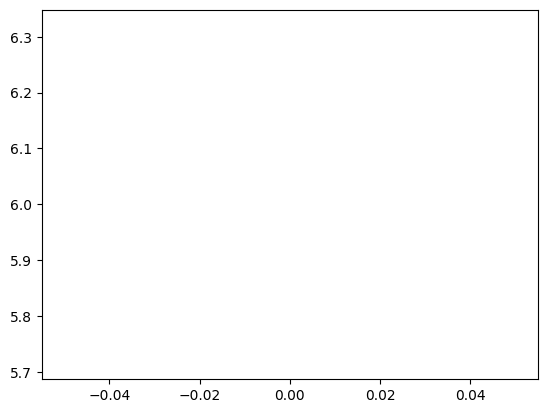

TRAIN TRUE: genre: ambient; instrument: synthesizer; mood/theme: soundscape

TRAIN PRED: genre: electronic, experimental, experimental; mood: somnospheric, somnospheric; mood: somnospheric, 
somnospheric, somnospheric

TEST TRUE: genre: electropop, pop, poprock; instrument: piano; mood/theme: corporate, energetic, playful, upbeat, 
uplifting

TEST PRED: genre: folk, folk, rock, country

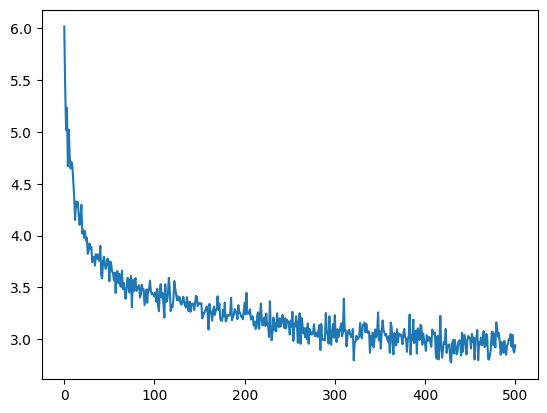

TRAIN TRUE: genre: indie, pop

TRAIN PRED: genre: pop, pop, pop, pop

TEST TRUE: genre: breakbeat, chillout, rap; instrument: organ; mood/theme: dark, dramatic, horror, religious, 
suspense

TEST PRED: genre: electronic, electronic; instrument: synthesizer, synthesizer, synthesizer

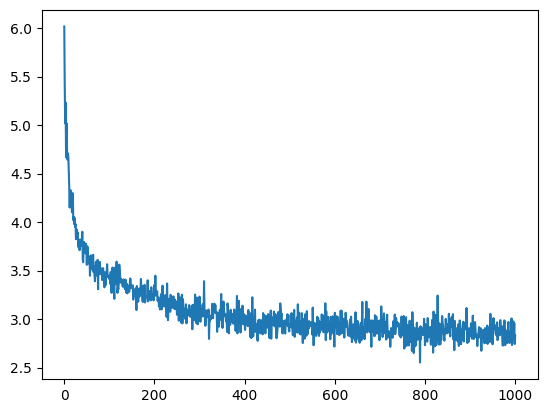

TRAIN TRUE: genre: soundtrack; instrument: piano; mood/theme: melodic

TRAIN PRED: genre: classical, classical, classical; instrument: piano

TEST TRUE: genre: ambient, drone, soundtrack; instrument: computer; mood/theme: cosmic, nostalgic

TEST PRED: genre: ambient, ambient

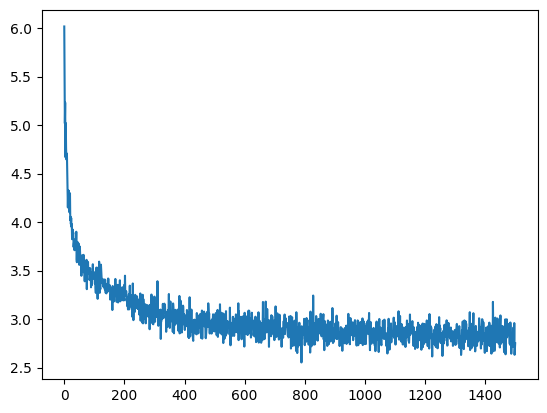

TRAIN TRUE: genre: electronic

TRAIN PRED: genre: ambient, ambient, ambient, ambientgenre: ambient, ambient

TEST TRUE: genre: folk, pop, popfolk; mood/theme: advertising, festive, happy, upbeat

TEST PRED: genre: pop, pop, pop, pop, pop, pop, pop, pop, pop

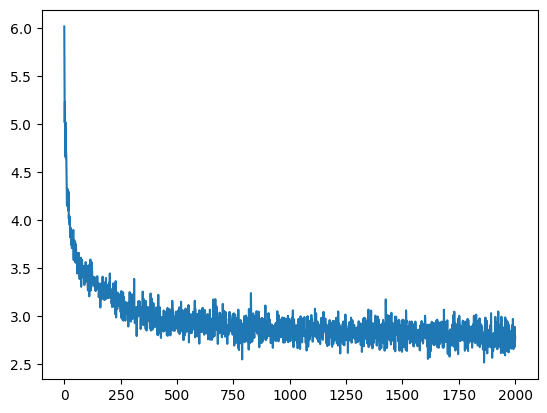

TRAIN TRUE: genre: indie, postrock, rock

TRAIN PRED: genre: rock, metal; instrument: synthesizer, synthesizer

TEST TRUE: genre: americana, blues, jazz

TEST PRED: genre: pop, pop, rockgenre: pop, pop, pop

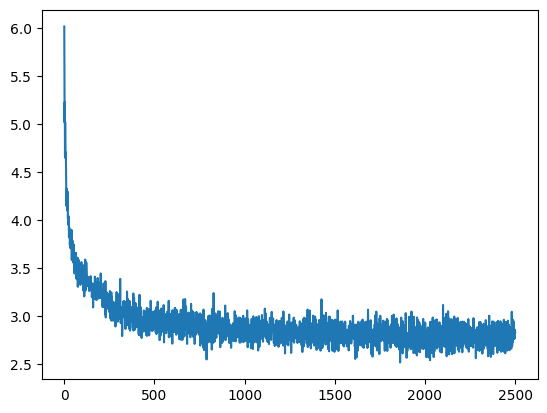

TRAIN TRUE: genre: chillout, rock

TRAIN PRED: genre: rock, rock; instrument: acoustic guitar

TEST TRUE: genre: electronic

TEST PRED: genre: ambient, ambient, ambient, ambient, ambient, ambient

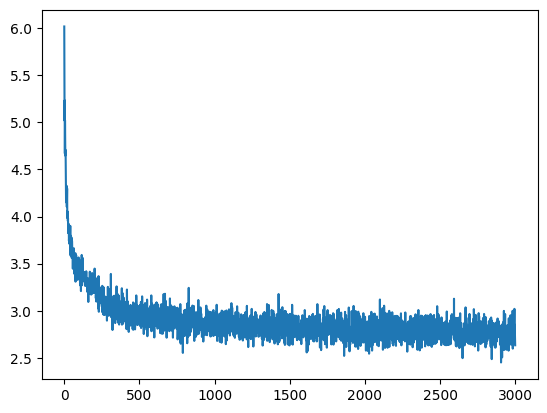

TRAIN TRUE: genre: dance, electronic

TRAIN PRED: genre: dance, electronic, electronic

TEST TRUE: genre: alternative, alternativerock, rock; mood/theme: life

TEST PRED: genre: pop, rock, pop

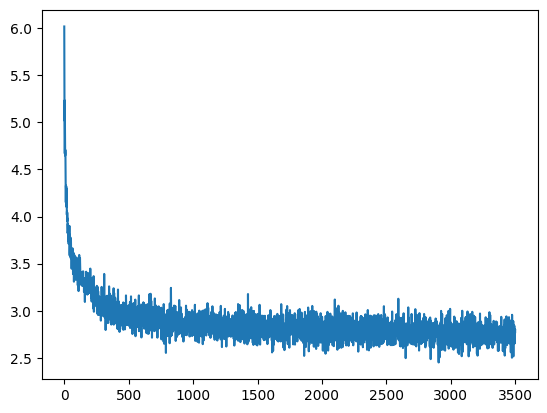

  0%|          | 0/3786 [00:00<?, ?it/s]

TRAIN TRUE: genre: ambient, electronic, soundtrack

TRAIN PRED: genre: ambient, experimental; mood: somatic; mood: somatic; mood: somatic

TEST TRUE: genre: soundtrack; mood/theme: movie

TEST PRED: genre: alternative, alternative, experimental, progressive, progressive, progressive, progressive

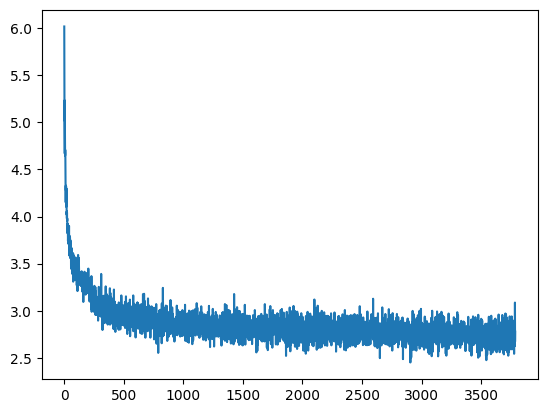

TRAIN TRUE: genre: 60s, atmospheric, rocknroll

TRAIN PRED: genre: rock, pop, pop

TEST TRUE: genre: alternative, ambient, electronic, experimental, industrial; mood/theme: dark

TEST PRED: genre: ambient, experimental; mood/theme: somnambient; instrument: synthesizer, synthesizer

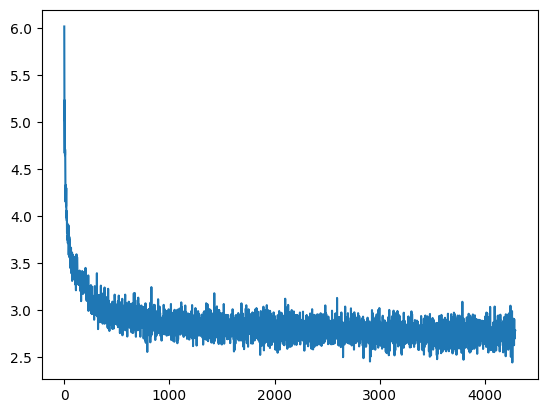

TRAIN TRUE: genre: electronic

TRAIN PRED: genre: electronic, electronic, electronic

TEST TRUE: genre: electrohouse, electronic, minimal, progressive, techno; instrument: bass, computer

TEST PRED: genre: dance, house

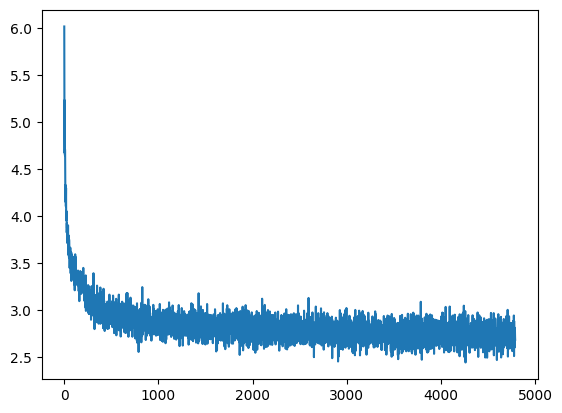

TRAIN TRUE: genre: easylistening, electronic

TRAIN PRED: genre: ambient, ambient; instrument: synthesizer; instrument: synthesizer

TEST TRUE: genre: hard, metal, progressive, rock; mood/theme: melodic

TEST PRED: genre: rock, metal

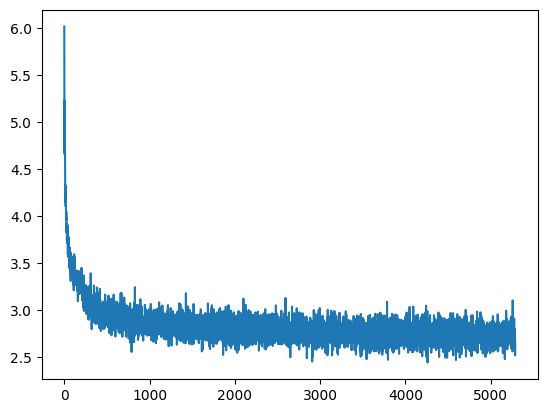

TRAIN TRUE: genre: house, techno, technopop

TRAIN PRED: genre: electronic, electronic

TEST TRUE: genre: hiphop, triphop; instrument: bell, cello, drummachine, drums, keyboard, orchestra, strings, 
synthesizer, viola, violin, woodwind

TEST PRED: genre: ambient, ambient, ambient, ambient, ambient, ambient

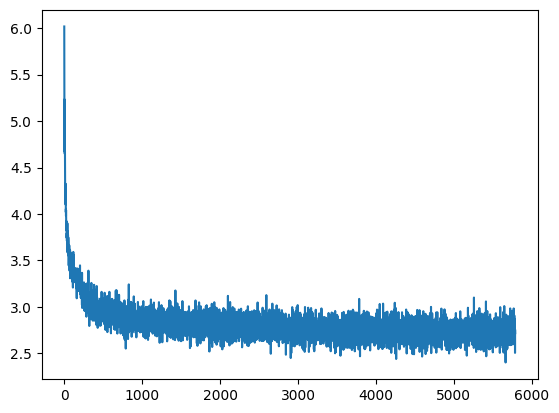

TRAIN TRUE: genre: alternative, indie, pop, rock; instrument: bass

TRAIN PRED: genre: rock, metal; instrument: electric guitar

TEST TRUE: genre: alternative, indie, postrock; mood/theme: epic, inspiring

TEST PRED: genre: rock, rock

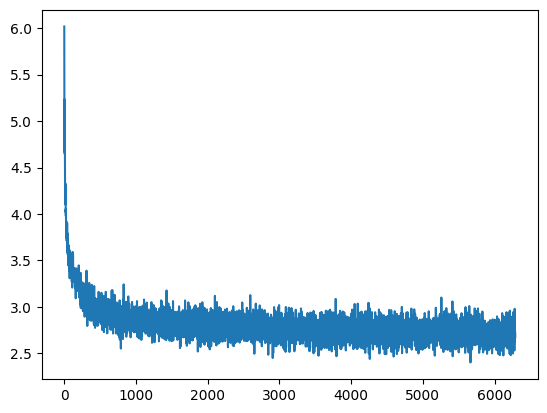

TRAIN TRUE: genre: jazz

TRAIN PRED: genre: rock, pop, jazz, jazz; instrument: acoustic guitar, acoustic guitar, electric bass; instrument: 
acoustic guitar, acoustic guitar, electric bass

TEST TRUE: genre: funk, rock, soundtrack; instrument: guitar; mood/theme: drive

TEST PRED: genre: pop, rock, rock

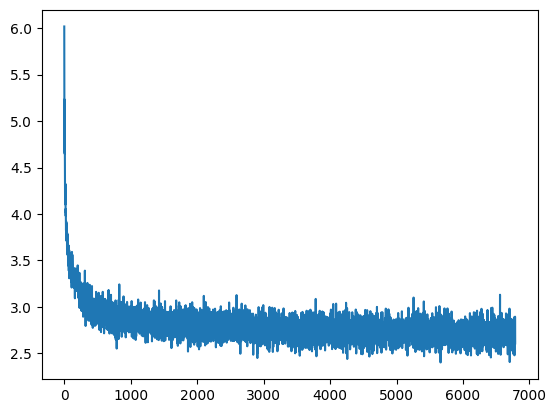

TRAIN TRUE: genre: chillout, downtempo, instrumentalhiphop, lofi, triphop; instrument: drummachine, sampler

TRAIN PRED: genre: ambient, ambient; instrument: synthesizer, synthesizer

TEST TRUE: genre: pop, popfolk; instrument: computer

TEST PRED: genre: classical, classical, classical; instrument: piano

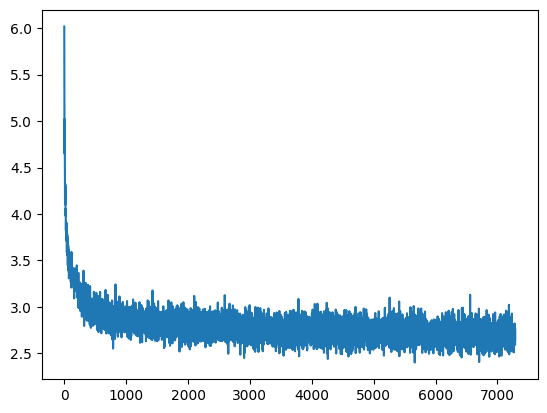

Started finetuning gpt2


  0%|          | 0/3786 [00:00<?, ?it/s]

TRAIN TRUE: genre: hiphop, rap, rnb; instrument: piano

TRAIN PRED: genre: pop, hiphop, hiphop

TEST TRUE: genre: pop, popfunk, reggae, reggaeton

TEST PRED: genre: house, house, house, house

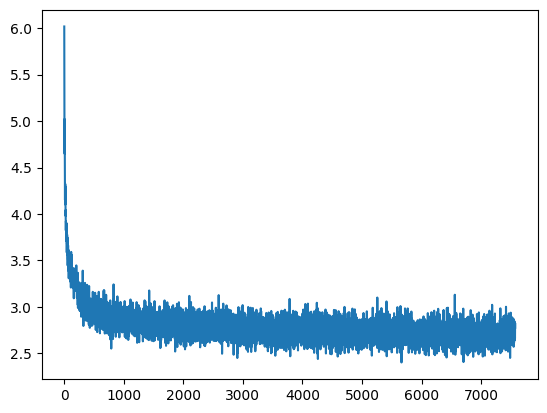

TRAIN TRUE: genre: pop, rock; instrument: drums, electricguitar; mood/theme: melancholic

TRAIN PRED: genre: pop, poprock; instrument: acousticguitar, electricguitar

TEST TRUE: genre: ambient, classical, easylistening, orchestral; instrument: celesta, cello, harp, piano, piccolo, 
trumpet, violin; mood/theme: relaxing, sad

TEST PRED: genre: classical, orchestral, classical; instrument: piano, violin

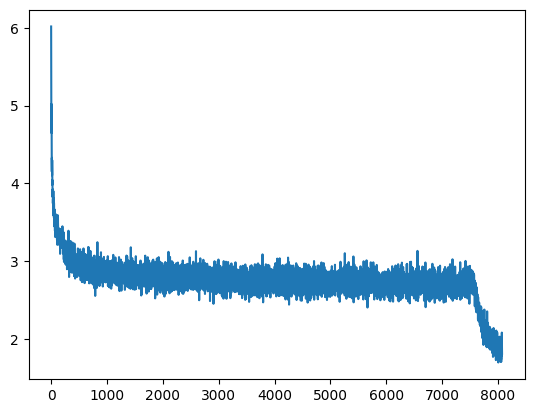

TRAIN TRUE: genre: pop

TRAIN PRED: genre: pop, poprock; instrument: guitar

TEST TRUE: genre: deephouse, electronic, house; instrument: guitar; mood/theme: deep

TEST PRED: genre: chillout, electronic; instrument: bass, drums, synthesizer

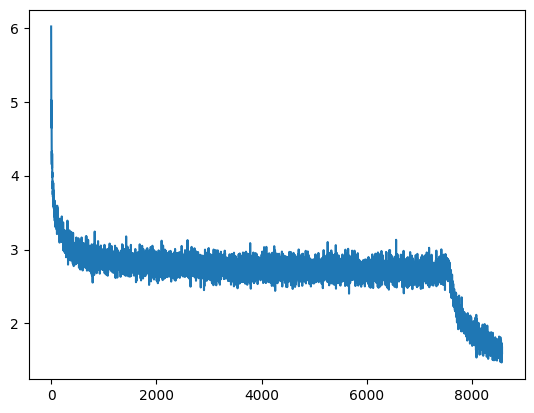

TRAIN TRUE: genre: classical; instrument: piano

TRAIN PRED: genre: classical; instrument: piano

TEST TRUE: genre: chillout, easylistening, newage; instrument: piano

TEST PRED: genre: ambient, easylistening, soundtrack; instrument: piano

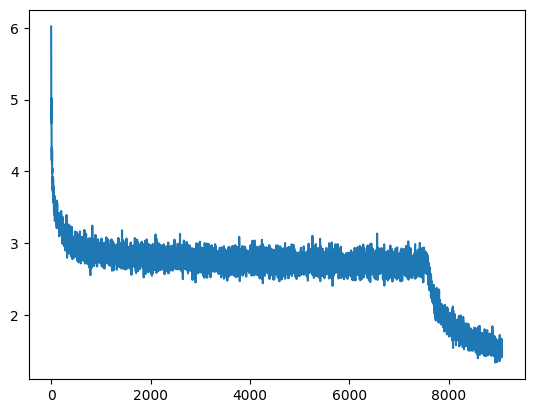

TRAIN TRUE: genre: easylistening, pop, popfolk; instrument: marimba, piano, ukulele; mood/theme: children, happy, 
positive

TRAIN PRED: genre: folk, popfolk; instrument: bass, drums, electricguitar; mood/theme: happy, happy, uplifting, 
uplifting

TEST TRUE: genre: country, soundtrack; instrument: acousticguitar; mood/theme: calm, happy, inspiring, optimistic, 
positive, warm

TEST PRED: genre: popfolk, popfolk; instrument: acousticguitar, guitar

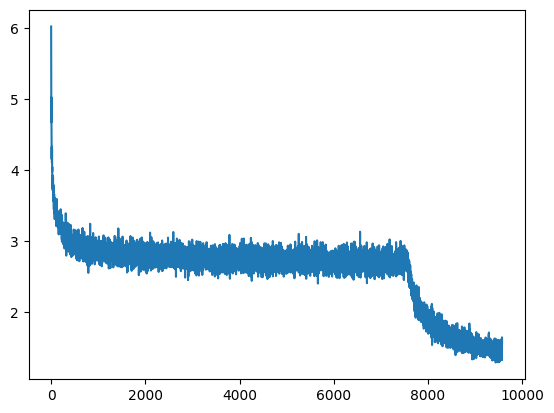

TRAIN TRUE: genre: soundtrack, tribal, world; instrument: jewsharp

TRAIN PRED: genre: folk, world; instrument: bass, drums, electricguitar

TEST TRUE: genre: deephouse, electronic, house, triphop

TEST PRED: genre: chillout, downtempo, downtempo; instrument: bass, drums, electricguitar, keyboard, synthesizer

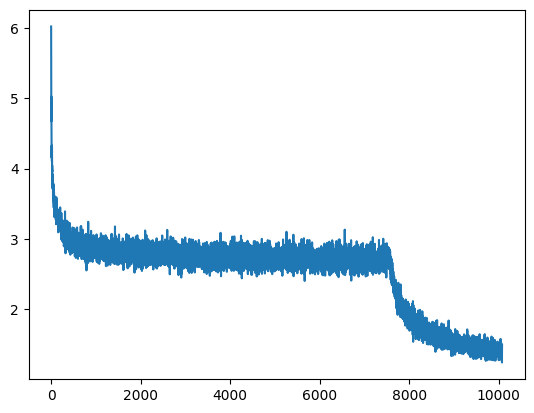

KeyboardInterrupt: 

In [19]:
for epoch in tqdm(range(epoch, num_epochs)):

    torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
    }, checkpoint_dir / f"chkp_{epoch}.pt")

    if epoch == gpt2_finetune_start_epoch:
        print("Started finetuning gpt2")
        for pg in opt.param_groups[1:]:
            pg["lr"] = gpt2_finetune_lr

    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(caption_batch)
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch, input_ids, input_ids_target
        )

        apply_grad_cond = step % gradient_acc_fact == 0
        losses.append(
            update_step(inputs_embeds, input_ids_target, apply_grad=apply_grad_cond)
        )

        if step % 500 == 0:
            eval_step()
            plt.plot(losses)
            plt.show()

# Generate eval captions

In [ ]:
eval_true_captions = []
eval_pred_captions = []

for j in range(1000):
    # load epoch checkpoint
    data_dict = torch.load(f'./checkpoints/chkp_{j}.pt')
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])

    # generate a bunch of captions with this checkpoint
    # for some reason hf generate() breaks atm when using batched captions, idk why
    true, preds = [], []
    for i, (caption_batch, embedding_batch) in enumerate(tqdm(eval_test_dataloader)):
        pred = eval(caption_batch, embedding_batch, **generation_params_hf)
        true.append(caption_batch[0])
        preds.append(pred[0])
        if i >= 300:
            break
        
    eval_true_captions.append(true)
    eval_pred_captions.append(preds)

In [ ]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions
), open('preds.json', 'w'))

In [89]:
import evaluate
google_bleu = evaluate.load("google_bleu")

gleu = []
for p, t in zip(eval_pred_captions, eval_true_captions):
    gleu.append(google_bleu.compute(predictions=p, references=t)['google_bleu'])
    
plt.plot(gleu)

# Old things

### manual autoregressive decoding

In [30]:
@torch.no_grad()
def manual_generate_single(inputs_embeds, max_length, do_sample):
    """ Autoregressively generate max_len tokens based on the embedded prompt. """
    result = []
    log_probs = []

    for i in range(max_length):
        logits = model.forward(inputs_embeds=inputs_embeds).logits[:, -1]

        distr = torch.distributions.Categorical(logits=logits)
        token_inds = distr.sample() if do_sample else logits.argmax(-1)
        log_probs.append(distr.log_prob(token_inds))
        
        result.append(token_inds)

        inputs_embeds = torch.cat([
            inputs_embeds,
            model.transformer.wte(token_inds).unsqueeze(1)
        ], dim=1)
        
    log_probs = torch.stack(log_probs, dim=1)
    ppl = 2**(-(1/len(log_probs))*log_probs.sum(-1))
        
    return torch.stack(result, dim=1), ppl

@torch.no_grad()
def manual_generate(inputs_embeds, iters, max_length, do_sample):
    """ Repeatedly generate samples using manual_generate_single and return the ones with the lowest perplexity. """
    preds = []
    ppls = []
    
    for i in range(iters):
        pred, ppl = manual_generate_single(inputs_embeds, max_length, do_sample)
        preds.append(pred)
        ppls.append(ppl)
    
    preds = torch.stack(preds)
    ppls = torch.stack(ppls)
    
    max_ppl_inds = ppls.argmin(0)
    best_preds = preds[max_ppl_inds, np.arange(preds.shape[1])]
    
    return best_preds, ppls.min(0)[0]

### image captioning gpt2

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
encoder_forward = model.encoder.forward

In [ ]:
EMBS = torch.zeros(1, 1, 768).to(device)

In [ ]:
def patched_forward(*args, **kwargs):
    result = encoder_forward(*args, **kwargs) # this is just to appease the HuggingFace gods
    result.last_hidden_state = (EMBS).repeat(1, 197, 1) # overwrite with actual embedding we use
    return result

# the original model uses a vision transformer in the encoder forward, so we get rid of that 
# and use the embeddings we have for the music

model.encoder.forward = patched_forward

In [ ]:
model.forward(torch.zeros(1, 3, 224, 224).to(device), labels=torch.zeros(1, 1).long().to(device))